In [1]:
%run 'Functions.ipynb'

In [2]:
def hist_terms(terms=None, interval='week', start='1900-01-01', end='2020-01-01'):
    q = Search(index='hep-analysis')[0:0]
    if terms:
        q = q.query('match_phrase', **{'abstracts.value': terms})
    q = q.filter('range', earliest_date={'gte': start, 'lt': end})
    q.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval=interval,
        format='date_optional_time'
    )
    return q.execute().aggregations.group_by_date.buckets

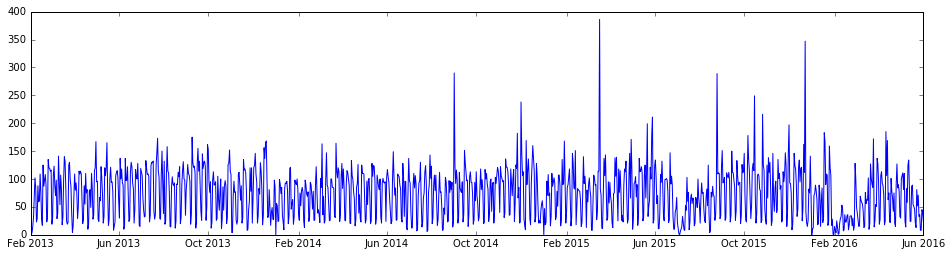

In [3]:
tx, ty = unzip(hist_terms(interval='1d'))
plt.plot(tx, ty)

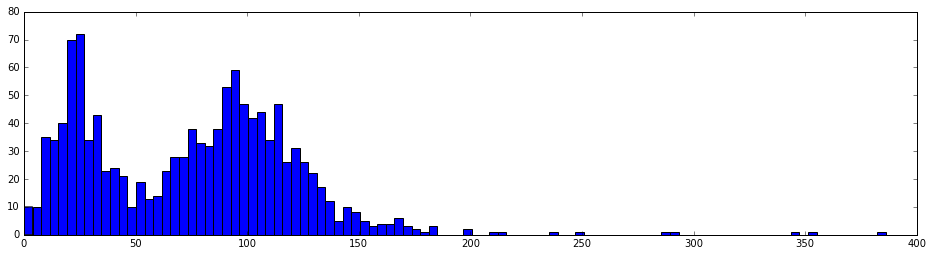

In [4]:
plt.hist(ty, bins=100)
plt.show()

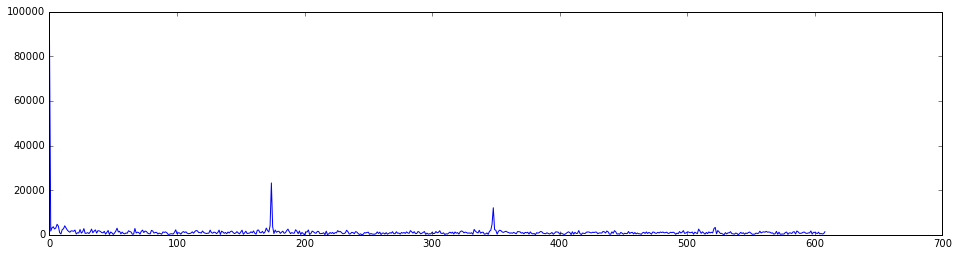

In [5]:
plt.plot(np.abs(np.fft.rfft(ty)))

In [6]:
fft = np.abs(np.fft.rfft(ty))
fft[fft < 12000] = 0

In [7]:
days = (max(tx)-min(tx)).days
days

1216

In [8]:
np.argsort(-fft)[:5]

array([  0, 174, 348, 403, 404])

In [9]:
np.nonzero(fft)

(array([  0, 174, 348]),)

In [10]:
1 / (np.nonzero(fft)[0][1:] / days)

array([ 6.98850575,  3.49425287])

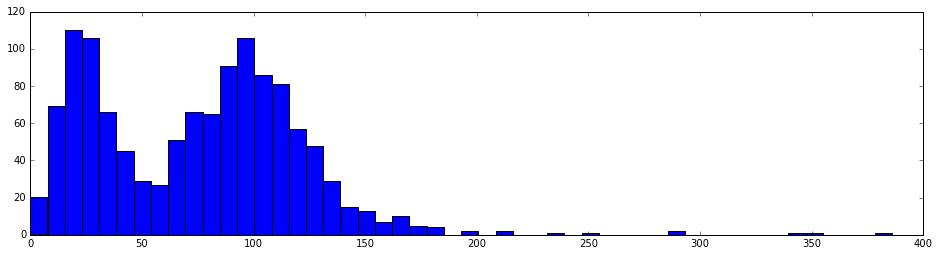

In [11]:
plt.hist(ty, bins=50)
plt.show()

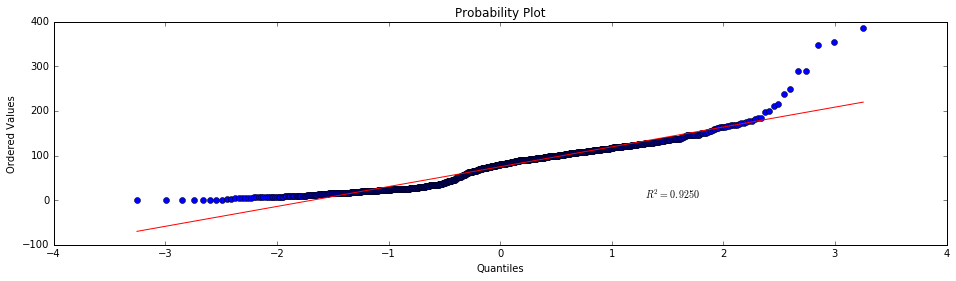

In [12]:
sp.stats.probplot(ty, dist="norm", plot=py)
py.show()

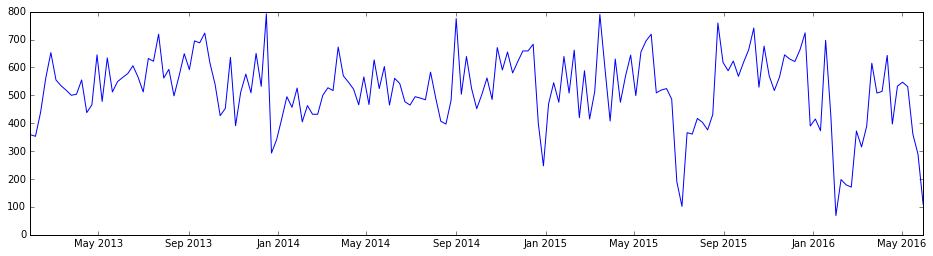

In [13]:
tx, ty = unzip(hist_terms())
plt.plot(tx, ty)

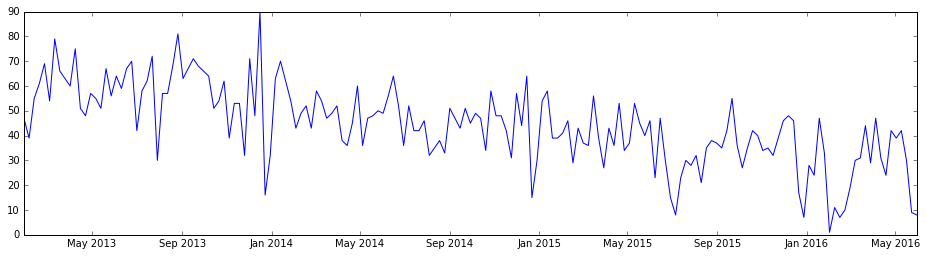

In [14]:
x, y = unzip(hist_terms('galaxy'))
plt.plot(x, y)

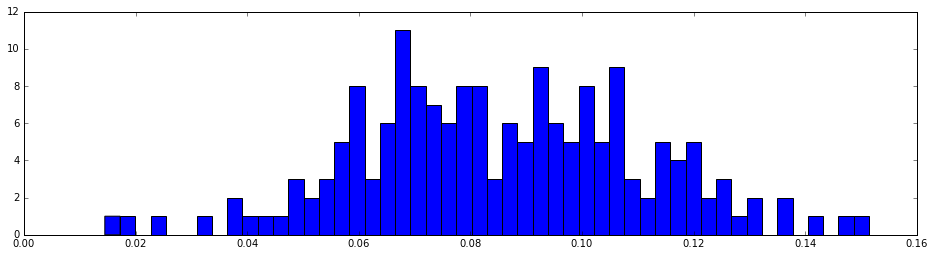

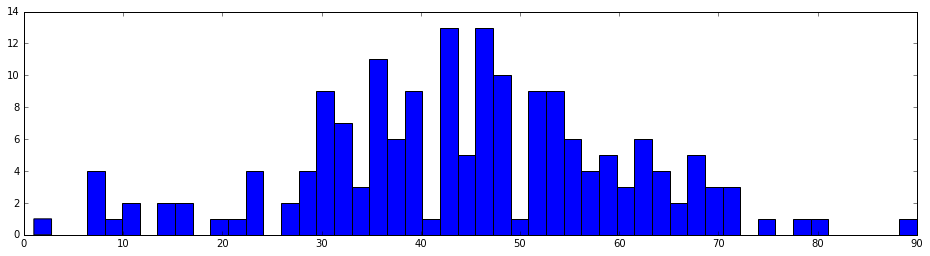

In [15]:
plt.hist(zero_div(y, ty), bins=50)
plt.show()
plt.hist(y, bins=50)
plt.show()

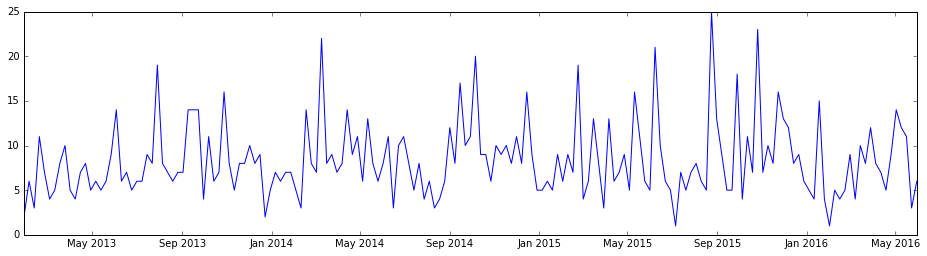

In [16]:
x, y = unzip(hist_terms('laser'))
plt.plot(x, y)

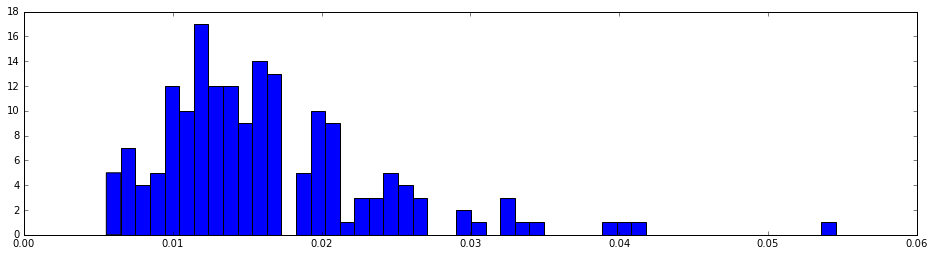

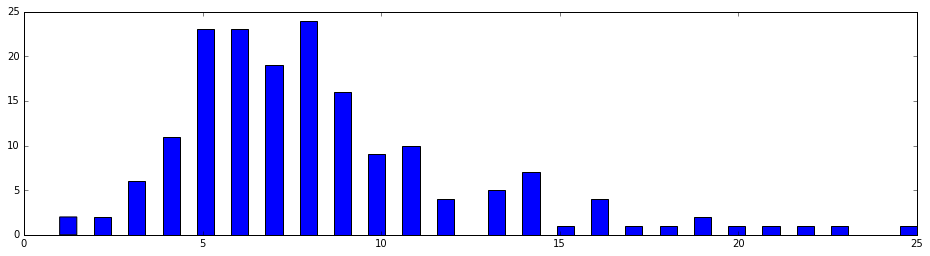

In [17]:
plt.hist(zero_div(y, ty), bins=50)
plt.show()
plt.hist(y, bins=50)
plt.show()

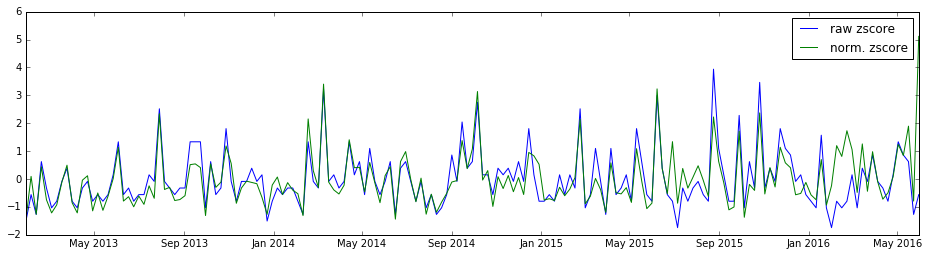

In [18]:
plt.plot(x, sp.stats.zscore(y), label='raw zscore')
plt.plot(x, sp.stats.zscore(zero_div(y, ty)), label='norm. zscore')
plt.legend()

In [19]:
id_week1 = interval_ids('2013-03-01')
id_week2 = interval_ids('2013-03-08')
id_week3 = interval_ids('2013-03-15')
id_week4 = interval_ids('2013-03-22')

In [20]:
terms_week1 = fold_vectors(term_vectors(id_week1, 'abstracts.value'))
terms_week2 = fold_vectors(term_vectors(id_week2, 'abstracts.value'))
terms_week3 = fold_vectors(term_vectors(id_week3, 'abstracts.value'))
terms_week4 = fold_vectors(term_vectors(id_week4, 'abstracts.value'))

In [21]:
terms_week1['higg']

{'doc_freq': 49, 'doc_total': 961, 'term_freq': 454, 'term_total': 7009}

In [22]:
terms_week2['higg']

{'doc_freq': 24, 'doc_total': 930, 'term_freq': 215, 'term_total': 6786}

In [23]:
terms_week3['higg']

{'doc_freq': 25, 'doc_total': 977, 'term_freq': 266, 'term_total': 7123}

In [24]:
terms_week4['higg']

{'doc_freq': 33, 'doc_total': 930, 'term_freq': 256, 'term_total': 6786}

In [25]:
raw = fold_vectors(term_vectors(interval_ids('2013-03-01', days=600), 'abstracts.value'))

In [26]:
selected = {}
for k, v in sorted(raw.items()):
    if v['doc_freq'] >= 25:
        selected[k] = v

In [27]:
len(selected)

19361

In [28]:
def align_origin(ax1, ax2):
    _, y1 = ax1.transData.transform((0, 0))
    _, y2 = ax2.transData.transform((0, 0))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1 - y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny + dy, maxy + dy)

In [29]:
def plot_scores(data, *scores):
    fig, ax1 = plt.subplots()
    for score, label in scores:
        ax1.plot(x, score , label=label)
    plt.legend()
    ax2 = ax1.twinx()
    ax2.fill_between(x, 0, data - np.ones(len(data)) * np.mean(data), facecolor='lightgrey', alpha=0.3)
    align_origin(ax1, ax2)
    plt.show()

In [30]:
spiky = []
for k, v in list(selected.items())[:100]:
    hist = hist_terms(k)
    if len(hist):
        x, y = unzip(hist_terms(k))
        start = np.where(tx == min(x))[0][0]
        end = np.where(tx == max(x))[0][0]
        scoped = ty[start:end+1]
        normalized = zero_div(y, scoped)
        zscore = sp.stats.zscore(normalized)
        chiscore = (normalized - np.mean(normalized)) ** 2 / np.mean(normalized)

        for index in np.where(zscore >= 3)[0]:
            spiky.append((x[index], k, zscore[index], chiscore[index]))

            #plot_scores(normalized, (zscore, 'zscore'), (chiscore * 100, 'chiscore'))

In [31]:
"%f%%" % ((1 - sp.stats.norm.cdf(4)) * 100)

'0.003167%'

In [32]:
len(spiky)

217

In [33]:
trends = {}
for k, v, zscore, chiscore in spiky:
    date = k.strftime("%Y-%m")
    elem = (v, zscore, chiscore)
    if date in trends:
        trends[date].append(elem)
    else:
        trends[date] = [elem]

In [34]:
top_trends = {}
for date, terms in sorted(trends.items()):
    top_trends[date] = [e for e in sorted(terms, key=lambda x: -x[1])]

In [52]:
for date, terms in sorted(top_trends.items()):
    print(date)
    for wordScore in terms:
        print('%s' % wordScore[0])
    print()

2013-01
spectral component
far
depolarize
theory massive

2013-02
infrared spectral
timelike
highly variable
spectral component
theory massive
observable quantity

2013-03
control sample
correct
within kpc
suggestive
total mass
specific star formation

2013-04
infrared spectral
thin film
newly discover
emanate
can give rise
newly discover
adapt optics system

2013-05
angular momentum transport
density dark
formalism develop
effective metric

2013-06
decrement
mach

2013-07
infrared spectral

2013-08
real imaginary
infrared spectral
lattice field theory
necessary condition
way find
onset

2013-09
suggestive
depolarize

2013-10
pi rho
decay result
experiment including
specific star formation
specific star formation
perot

2013-11
along way
highly variable

2013-12
limit large
internal external
specific star formation
positron annihilate
weak interaction
internal external
uranium
loop induce

2014-01
wash
necessary condition
relatively low
density high

2014-02
energy de
often use
formali

In [36]:
def repeat_sides(num, arr):
    arr = np.array(arr)
    left = np.ones(num) * arr[0]
    right = np.ones(num) * arr[-1]
    return np.append(left, np.append(arr, right))

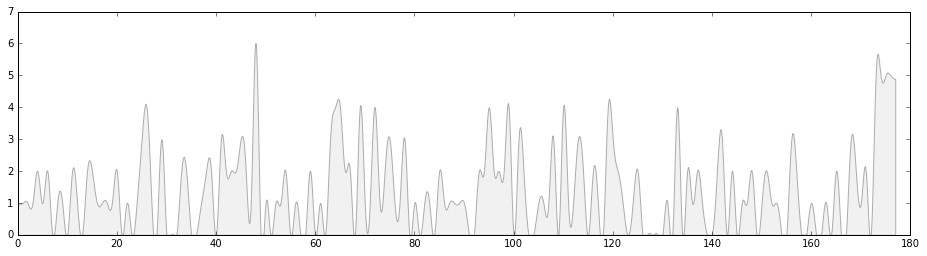

In [45]:
data = repeat_sides(3, y)
inter = sp.interpolate.Rbf(range(len(data)), data)
x_new = np.arange(0, len(data), 0.05)
y_new = inter(x_new)
y_new[y_new < 0] = 0 
#plt.plot(inter, spl(inter))
plt.fill_between(x_new, 0, y_new, facecolor='lightgrey', alpha=0.3)
#plt.plot(data)

In [40]:
import requests
import json

In [51]:
WORD2VEC_URL = 'http://magpie.inspirehep.net/api/word2vec'
headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}

data = {'corpus': 'keywords', 'positive': ['susy'], 'negative': []}

response = requests.post(WORD2VEC_URL, data=json.dumps(data), headers=headers)
json.loads(response.text)

{'status_code': 200,
 'vector': [['supersymmetry', 0.8403844833374023],
  ['gmsb', 0.8129041194915771],
  ['gravity-mediated', 0.7952372431755066],
  ['anomaly-mediated', 0.7948304414749146],
  ['guts', 0.7941287755966187],
  ['gauge-mediated', 0.7885528206825256],
  ['yukawa-unified', 0.7875216007232666],
  ['high-scale', 0.7867831587791443],
  ['mini-split', 0.7847812175750732],
  ['amsb', 0.7800101637840271]]}